# Pneumonia XRay Classification using a CNN
## Instructions:
* Using code cell bellow mount `Google Drive` to this notebook (please accept access permissions).
* Download and upload linked dataset [.zip file](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) to `My Drive` folder of **your** `Google Drive`.
* Adjust parameters in "Hyper-parameters" section to decide on various features.
* Select .zip file name in "Hyper-parameters" section.


## Important:
* .zip file must be present in drive/MyDrive/< .zip file name >
* .zip file data extracted to drive/MyDrive/ML Data Sets/< folder name >
* Checkpointing of models saved to drive/MyDrive/ML Models/< model name >
* Train and Test history of models saved to drive/MyDrive/ML Models/Train and Test Data/< model name >


In [ ]:
# Mount Google Drive to Collab (please accept access permissions)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Hyper-parameters
* Set training hyper-parameters.
* Choose the filename which your .zip dataset is named as.
* Choose the foldername to which .zip file data will be extracted to.
* Choose to enable loading pre-saved model, save best model after training, checkpointing.
* Choose to enable function to evaluate model test loss, test accuracy, Confusion Matrix and AUROC.


In [ ]:
# .zip file name
ZIP_NAME = "Pneumonia_DeepTek.zip"
FOLDER_NAME = "Pneumonia_DeepTek"

# Loading a Model and its Train and Test History
load_status = True         # Load model from GDrive (drive/MyDrive/ML Models/<MODEL_NAME>) pre-training i.e. resuming progress
LOAD_NAME = "CNN_v2"       # MODEL_NAME to be loaded

# Saving a Model (state_dict only)
save_status = True         # Save model to GDrive (drive/MyDrive/ML Models/<MODEL_NAME>) [ RECOMMENDED: True for Checkpointing ]
SAVE_NAME = "CNN_v2"       # MODEL_NAME to be saved

# Evaluate Model
evaluate_status = True     # Load and evaluate model on test data using various evaluation metrics (Section 3.6)
EVALUATE_NAME = SAVE_NAME  # MODEL_NAME to be evaluated

# Learning Rate
LR = 0.005

# Early Stopping Patience ( Stop training if no improvement in test loss after specificed number of epochs )
PATIENCE = 10
early_stop_status = True   # Set to True to turn on Early Stopping

# Input Resolution Image will be resized and passed to CNN
RESIZED_RESOLUTION = 256

## 3.1 Setup and Data

### 3.1.1 Libraries Setup

In [ ]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Data Loader
from torch.utils.data import DataLoader

# Mathplotlib
import matplotlib.pyplot as plt

# Pathlib
from pathlib import Path

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Version and Device
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Device: {device}")

PyTorch version: 2.3.0+cu121
torchvision version: 0.18.0+cu121
Device: cuda


### 3.1.2 Loading Data ( Pneumonia Chest X-ray )

#### Directory in Google Drive

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setting up Paths
data_path = Path("data/")
drive_path = Path("drive/MyDrive")
data_sets_path = drive_path / "ML Data Sets"
pneumonia_path = data_sets_path / FOLDER_NAME

# Checking if image folder exists in GDrive
if data_sets_path.is_dir():
  print(f"{data_sets_path}: directory exists.")
else:
  print(f"Did not find '{data_sets_path}' directory. Making directory in GDrive...")
  data_sets_path.mkdir(parents = True, exist_ok = True)

# Checking if Pneumonia Data Set is unzipped
if not (pneumonia_path).is_dir():
  # Unzipping
  with zipfile.ZipFile(drive_path / ZIP_NAME, "r") as zip_ref:
    print("Unzipping Pneumonia Data Set")
    zip_ref.extractall(data_sets_path)
    print("Done")
else:
  print(f"{pneumonia_path}: files exists. No unzipping.")

drive/MyDrive/ML Data Sets: directory exists.
drive/MyDrive/ML Data Sets/Pneumonia_DeepTek: files exists. No unzipping.


#### Directory Details

In [ ]:
import os
def walk_through_dir(dir_path, print_dir = False):
  """
  Walks through dir_path returning % of Normal Test, Train, Val Images
  If print_dir = True: Function returns all directories and files present in dir_path

  Args:
    dir_path (str or pathlib.Path): target directory
    print_dir (boolean, optional): Print directories and files in dir_path (default: False)

  Prints:
    % of Normal Test, Train, Val Images
    Optionally print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """

  # Printing directories
  if (print_dir):
    for dirpath, dirnames, filenames in os.walk(dir_path):
      print(f"There are {dirnames} directories and {len(filenames)} images in '{dirpath}'.")
    print("")

  # Image counters
  train_normal = 0
  train_pneumonia = 0
  test_normal = 0
  test_pneumonia = 0
  val_normal = 0
  val_pneumonia = 0
  # Counting images
  for dirpath, dirnames, filenames in os.walk(dir_path):
    for filename in filenames:
      if "test" in dirpath:
        if "NORMAL" in dirpath:
          test_normal += 1
        else:
          test_pneumonia += 1
      #------------------------
      elif "train" in dirpath:
        if "NORMAL" in dirpath:
          train_normal += 1
        else:
          train_pneumonia += 1
      #------------------------
      elif "val" in dirpath:
        if "NORMAL" in dirpath:
          val_normal += 1
        else:
          val_pneumonia += 1
  # Printing number of images in each category
  print(f"In training data: {train_normal} normal and {train_pneumonia} pneumonia | Normal is: {train_normal/(train_normal+train_pneumonia)*100 :.2f}%")
  print(f"In testing data: {test_normal} normal and {test_pneumonia} pneumonia | Normal is: {test_normal/(test_normal+test_pneumonia)*100 :.2f}%")
  print(f"In validation data: {val_normal} normal and {val_pneumonia} pneumonia | Normal is: {val_normal/(val_normal+val_pneumonia)*100 :.2f}%")

In [ ]:
walk_through_dir(pneumonia_path)

In training data: 1341 normal and 3874 pneumonia | Normal is: 25.71%
In testing data: 234 normal and 390 pneumonia | Normal is: 37.50%
In validation data: 8 normal and 8 pneumonia | Normal is: 50.00%


#### Removing Corrupted Images

In [ ]:
file_path_corrupted = "drive/MyDrive/ML Data Sets/Pneumonia_DeepTek/train/PNEUMONIA/person1142_bacteria_3086.jpeg"
try:
  os.remove(file_path_corrupted)
  print(f"File '{file_path_corrupted}' deleted successfully.")

except FileNotFoundError: print(f"File '{file_path_corrupted}' not found.")

File 'drive/MyDrive/ML Data Sets/Pneumonia_DeepTek/train/PNEUMONIA/person1142_bacteria_3086.jpeg' not found.


#### Meta-Data and Data Transformations

In [ ]:
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Random Image Choice
image_path_list = list(pneumonia_path.glob("*/*/*.jpeg"))
random_image = random.choice(image_path_list)
image_class = random_image.parent.stem
img = Image.open(random_image)

# Turn the image into an array
img_as_array = np.asarray(img)

# -------------------------------------------------------

from torchvision import datasets, transforms
from torchvision.transforms import v2
from torchvision.transforms import functional as F

In [ ]:
# Training Data Augmentation
data_transform = v2.Compose([
  v2.Grayscale(1),
  v2.RandomRotation(20),
  v2.RandomHorizontalFlip(p=0.5),
  v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
  v2.RandomApply([transforms.RandomAffine(0, translate=(0.05, 0.3))], p=0.5),
  v2.RandomApply([transforms.RandomPerspective(distortion_scale=0.2)], p=0.5),
  v2.Resize(size=(RESIZED_RESOLUTION, RESIZED_RESOLUTION)),
  v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
  v2.Normalize(mean=[0.485], std=[0.229]),
])

# Test Val Transform
data_transform_testval = v2.Compose([
  v2.Grayscale(1),
  v2.Resize(size=(RESIZED_RESOLUTION, RESIZED_RESOLUTION)),
  v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
  v2.Normalize(mean=[0.485], std=[0.229]),
])

(-0.5, 935.5, 567.5, -0.5)

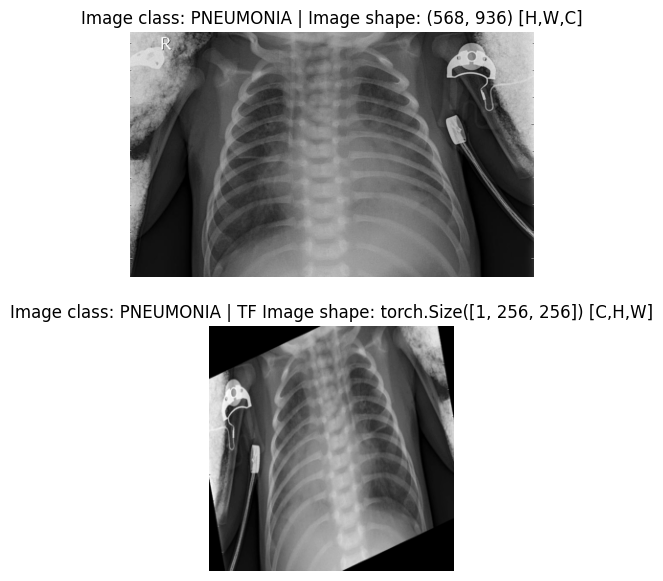

In [ ]:
# Applying transformations
transformed_image = data_transform(img)

s = 3
# Plot the transformed image
plt.figure(figsize=(21/s,21/s))
plt.subplot(2,1,2)
plt.title(f"Image class: {image_class} | TF Image shape: {transformed_image.shape} [C,H,W]")
plt.imshow(transformed_image.permute(1, 2, 0), cmap = "gray")
plt.axis(False)

# Plot the original image
plt.subplot(2,1,1)
plt.imshow(img_as_array, cmap = "gray")
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} [H,W,C]")
plt.axis(False)

#### Train, Test, Val Data

In [ ]:
train_data = datasets.ImageFolder(root = pneumonia_path / "train", transform = data_transform, target_transform = None)
test_data = datasets.ImageFolder(root = pneumonia_path / "test", transform = data_transform_testval)
val_data = datasets.ImageFolder(root = pneumonia_path / "val", transform = data_transform_testval)

### 3.1.3 Checking data and labels

* PyTorch generally accepts `NCHW` (channels first) as the default for many operators.

In [ ]:
image, label = train_data[random.randint(0, len(train_data))]

# Data Shape
print(f"Train images: {len(train_data)}")
print(f"Test images: {len(test_data)}")
print(f"Val images: {len(val_data)}")

# Image label
print(f"\nImage tensor shape (C,H,W): {image.shape} | Label: {label}")

# Image length
#print(f"{len(train_data.data)}, {len(train_data.targets)}, {len(test_data.data)}, {len(test_data.targets)}")

# Class names
print(f"\nClass names: {train_data.class_to_idx}")

Train images: 5215
Test images: 624
Val images: 16

Image tensor shape (C,H,W): torch.Size([1, 256, 256]) | Label: 1

Class names: {'NORMAL': 0, 'PNEUMONIA': 1}


### 3.1.4 Random Image from data

* In order to check effectiveness and resuslts of the transformations we applied

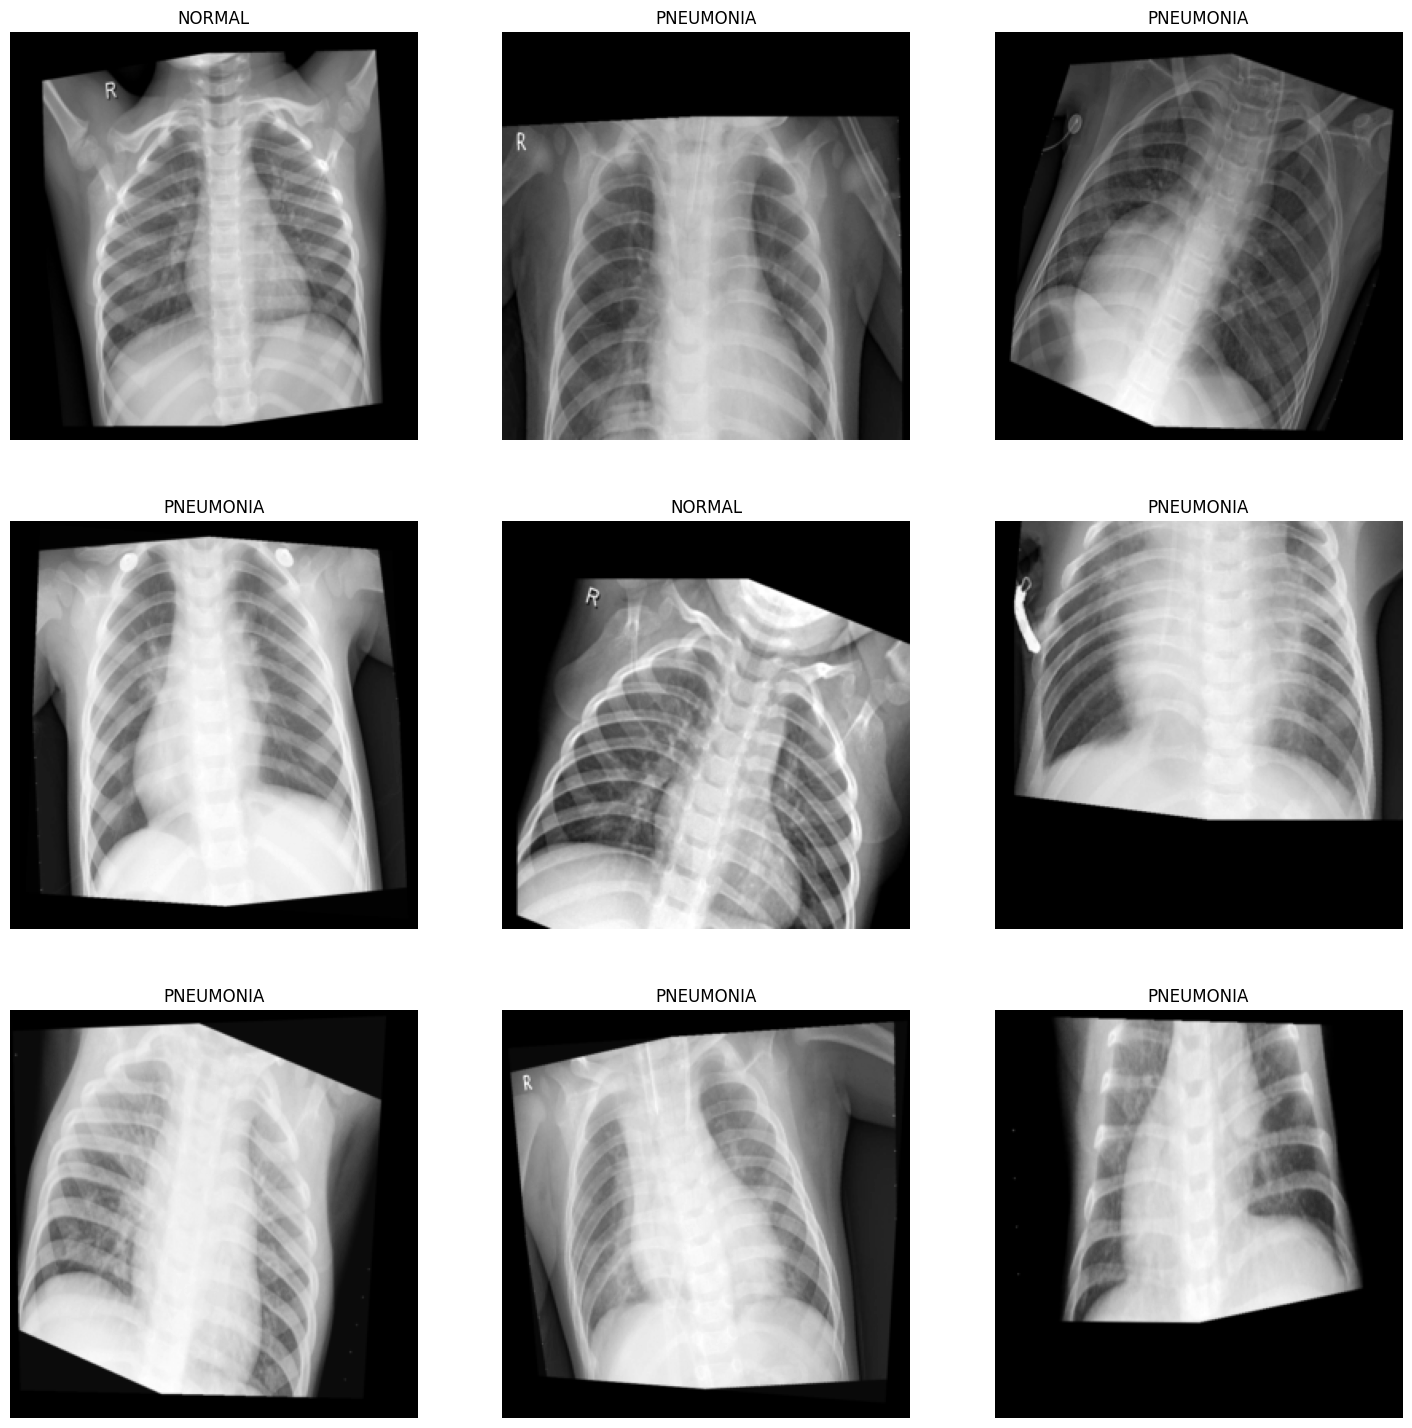

In [ ]:
import matplotlib.pyplot as plt

#torch.manual_seed(42)
#random.seed(42)

fig = plt.figure(figsize = (18,18))
rows, cols = 3, 3

for i in range(1, rows*cols + 1):
  random_idx = torch.randint(0, len(train_data), size = [1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.permute(1, 2, 0), cmap = "gray")
  plt.title(train_data.classes[label])
  plt.axis(False)

## 3.2 Data Loader

In [ ]:
from torch.utils.data import DataLoader

# Batch size
BATCH_SIZE = 32

# Turn datasets into iterables
train_dataLoader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
test_dataLoader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = False)
val_dataLoader = DataLoader(val_data, batch_size = BATCH_SIZE, shuffle = True)

# Checking DataLoader
print(f"DataLoaders: {train_dataLoader, test_dataLoader}")
print(f"Length of train_dataLoader: {len(train_dataLoader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataLoader: {len(test_dataLoader)} batches of {BATCH_SIZE}")

# Check out what's inside the training dataloader
print("")
train_features_batch, train_labels_batch = next(iter(train_dataLoader))
print(f"NCHW shape for Train Batch: {train_features_batch.shape} | Shape of Train Batch labels {train_labels_batch.shape}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7ccd8cc770a0>, <torch.utils.data.dataloader.DataLoader object at 0x7ccd8cc76dd0>)
Length of train_dataLoader: 163 batches of 32
Length of test_dataLoader: 20 batches of 32

NCHW shape for Train Batch: torch.Size([32, 1, 256, 256]) | Shape of Train Batch labels torch.Size([32])


## 3.3 Building CNN Model

### 3.3.1 Class Code

In [ ]:
class CNNv1(nn.Module):
  """
  CNN Model with 2 blocks
  Each block has:
    1. Conv2d
    2. ReLU
    3. MaxPool2d
  Fully connected Neural Network as the last layer
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int, inp_res: int):
    super().__init__()
    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),
        nn.Dropout(0.25),
    )
    self.block2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, 3, stride = 1, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, 3, stride = 1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
        # We want to flatten ALL features, DONT add dropout here
    )
    self.dense_neural_network = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(0.25),
        # Patting = 1 and CNN_kernel = 3 => no change in resolution | 2x MaxPool2d => resolution/4
        nn.Linear(hidden_units*(inp_res//4)*(inp_res//4), output_shape)
    )

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.dense_neural_network(x)
    return x

# Manual seed to "control" randomness of w and b when instantiating a new model
torch.manual_seed(42)
model_1 = CNNv1(input_shape = 1, hidden_units = 15, output_shape = len(train_data.classes), inp_res = RESIZED_RESOLUTION).to(device)
# Initializing test, train lists
train_loss_list = []
train_acc_list  = []
test_loss_list  = []
test_acc_list   = []

model_1

CNNv1(
  (block1): Sequential(
    (0): Conv2d(1, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense_neural_network): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p=0.25, inplace=False)
    (2): Linear(in_features=61440, out_features=2, bias=True)
  )
)

### 3.3.2 Checking Batch and Batch predictions shapes

In [ ]:
for batch, (X, y) in enumerate(train_dataLoader):
  # Send data to GPU
  X, y = X.to(device), y.to(device)
  y_preds = model_1(X)

  # Shapes
  print(f"Batch: {batch}: X shape: {X.shape} | y shape: {y.shape}")
  print(f"y_preds shape: {y_preds.shape} | max prob: {y_preds.argmax(dim=1).shape}")
  break

Batch: 0: X shape: torch.Size([32, 1, 256, 256]) | y shape: torch.Size([32])
y_preds shape: torch.Size([32, 2]) | max prob: torch.Size([32])


## 3.4 Functions to Load and Save | Callbacks

### 3.4.1 Load and Save Model


In [ ]:
def load_model(MODEL_NAME: str, model, load_lists = False):
  """
  Loads specified model saved in GDrive to model_1
  - Loads model state_dict
  - Loads train, test lists
  """
  # Loading model state dict
  MODEL_PATH = Path("drive/MyDrive/ML Models")
  MODEL_NAME_pth = MODEL_NAME + ".pth"
  MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME_pth
  model.load_state_dict(torch.load(f = MODEL_SAVE_PATH, map_location = device))
  print(f"{MODEL_NAME} loaded successfully.")

  # Loading Lists
  if load_lists:
    LISTS_SAVE_PATH = Path("drive/MyDrive/ML Models/Train Test Data/"+ MODEL_NAME)
    try:
      trl = np.load(f"{LISTS_SAVE_PATH}/trl_{MODEL_NAME}.npy")
      tracc = np.load(f"{LISTS_SAVE_PATH}/tracc_{MODEL_NAME}.npy")
      tstl = np.load(f"{LISTS_SAVE_PATH}/tstl_{MODEL_NAME}.npy")
      tstacc = np.load(f"{LISTS_SAVE_PATH}/tstacc_{MODEL_NAME}.npy")
      print("Train and Test Lists loaded successfully.")
      return list(trl), list(tracc), list(tstl), list(tstacc)
    except OSError as e:
      print("Train, Test Lists do not exist")

In [ ]:
def save_model(MODEL_NAME: str, model) -> None:
  """
  Saves current model_1 as a specified model in GDrive
  """
  # Creating models directory
  MODEL_PATH = Path("drive/MyDrive/ML Models")
  if not MODEL_PATH.is_dir():
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    print(f"Made directory: {MODEL_PATH}")

  # Creating save path
  MODEL_NAME = MODEL_NAME + ".pth"
  MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

  # Saving model state_dict
  torch.save(obj = model.state_dict(), f = MODEL_SAVE_PATH)
  print(f"Model saved as {MODEL_NAME}")

In [ ]:
def save_list(MODEL_NAME: str, trl, tracc, tstl, tstacc):
  # Making a directory to save lists
  LISTS_SAVE_PATH = Path("drive/MyDrive/ML Models/Train Test Data/"+ MODEL_NAME)
  if not LISTS_SAVE_PATH.is_dir():
    LISTS_SAVE_PATH.mkdir(parents = True, exist_ok = True)
    print(f"Made directory: {LISTS_SAVE_PATH}")

  # Saving Lists
  np.save(f"{LISTS_SAVE_PATH}/trl_{MODEL_NAME}.npy", trl)
  np.save(f"{LISTS_SAVE_PATH}/tracc_{MODEL_NAME}.npy", tracc)
  np.save(f"{LISTS_SAVE_PATH}/tstl_{MODEL_NAME}.npy", tstl)
  np.save(f"{LISTS_SAVE_PATH}/tstacc_{MODEL_NAME}.npy", tstacc)
  print("Train and Test Lists saved successfully.")

### 3.4.2 Early Stopping and Checkpointing

* Creating a class -> Different objects of class can have different thresholds
* `__call__()` method called each time object of class is called with apt. params

In [ ]:
class EarlyStopping:
  def __init__(self, patience = 5, min_delta = 0.0, restore_best_weights = True):
    self.patience = patience
    self.min_delta = min_delta
    self.restore_best_weights = restore_best_weights
    self.best_model = None
    self.best_loss = None
    self.best_epoch = None
    self.counter = 0
    self.status = ""

  def __call__(self, model, MODEL_NAME: str, save_status, early_stop_status, test_loss, epoch):
    # Fresh model training
    if self.best_loss == None:
      if save_status: save_model(MODEL_NAME, model)
      self.best_loss = test_loss
      self.best_epoch = 1
    # Improvement more than min_delta
    elif (self.best_loss - test_loss) > self.min_delta:
      if save_status: save_model(MODEL_NAME, model)
      self.best_loss = test_loss
      self.best_epoch = epoch+1
      self.status = f"Improvement found in epoch: {epoch+1} | After: {self.counter} epochs"
      print(self.status)
      self.counter = 0
    # no improvement
    else:
      self.counter += 1
      self.status = f"No improvement found in the last {self.counter} epochs"
      print(self.status)
      # Patience exceeded and early_stop_status = True
      if self.counter >= self.patience and early_stop_status:
        self.status = f"Early Stopping"
        print(self.status)
        if self.restore_best_weights and save_status:
          print("Restoring best model to model_1")
          load_model(MODEL_NAME, model)

Early1 = EarlyStopping(patience = PATIENCE, min_delta = 0.001)

## 3.5 Optimiser, Loss fn | Training and Testing Code

### 3.5.1 Optimiser, Loss Function and custom Accuracy Function

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RAdam(params = model_1.parameters(), lr = LR)                        # Keep a LOW LR for RAdam and Adam 0.001 - 0.01
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 15, last_epoch=-1) # Change last_epoch when using Adam for last 12 ephocs

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

### 3.5.2 Checking if model has been loaded
* Accuracy and loss values should be similar to that of the model we loaded
* Accuracy on test set will be low if model_1 = random NEW model  

#### Check Model function

In [ ]:
def check_model(model):
  # Initialization
  test_loss, test_acc = 0, 0

  # Single batch to check acc
  model.eval()
  with torch.inference_mode():
    for (X, y) in tqdm(test_dataLoader):
      # Send data to GPU
      X, y = X.to(device), y.to(device)
      # Forward Pass
      test_pred = model(X)
      loss = loss_fn(test_pred, y)
      # Batch loss and acc
      test_loss += loss
      test_acc += accuracy_fn(y_true = y, y_pred = test_pred.argmax(dim = 1))

    # Output
    test_loss /= len(test_dataLoader)
    test_acc /= len(test_dataLoader)
    return test_loss, test_acc

#### Resuming Progress

In [ ]:
# Printing result  ( Enter MODE_NAME without .pth extension )
if load_status: train_loss_list, train_acc_list, test_loss_list, test_acc_list = load_model(LOAD_NAME, model_1, load_lists = True); print("")
test_loss, test_acc = check_model(model_1)
print(f"Test loss: {test_loss:.3f} | Test accuracy: {test_acc:.2f}%")
print(f"Train loss list: {train_loss_list}")
print(f"Train acc  list: {train_acc_list}")
print(f"Test  loss list: {test_loss_list}")
print(f"Test  acc  list: {test_acc_list}")

# Updating Checkpointing to resume progress
Early1.best_loss = test_loss

CNN_v2 loaded successfully.
Train and Test Lists loaded successfully.



  0%|          | 0/20 [00:00<?, ?it/s]

Test loss: 0.329 | Test accuracy: 87.34%
Train loss list: [0.4875405728816986, 0.3805084228515625, 0.3418028652667999]
Train acc  list: [77.77805264199485, 84.1053582030477, 85.71516920641203]
Test  loss list: [0.33657848834991455, 0.3294757008552551, 0.4396577775478363]
Test  acc  list: [86.25, 87.34375, 79.21875]


### 3.5.3 Training and Testing Functions

#### Train Step

In [ ]:
def train_step(model : torch.nn.Module,
               data_loader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               optimizer : torch.optim.Optimizer,
               accuracy_fn,
               train_loss_list, train_acc_list,
               device : torch.device = device):
  """
  Procedure that takes place in each epoch
  """

  # Initialization
  train_loss, train_acc = 0, 0
  model.to(device)

  # Batch Loop
  try:
    for batch, (X,y) in tqdm(enumerate(data_loader)):
      model.train()

      # Send data to GPU
      X = X.to(device)
      y = y.to(device)

      # Forward Pass
      y_pred = model(X)
      # Train Loss and Accuracy
      loss = loss_fn(y_pred, y)  # Output shape of CNN(y_pred): [m, 2] where m = batch size and 2 = NORMAL, PNEUMONIA
      train_loss += loss
      train_acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim = 1))

      # Backpropagation and Gradient Descent
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Print out how many samples have been seen
      if batch % 40 == 0:
        print(f"Looked at {batch * len(X)}/{len(train_dataLoader.dataset)} samples")

  except OSError as e:
    print(f"OSError {e} in Batch, Skipping Batch")

  # Calculate loss and accuracy per epoch (Sum of train losses for all batches/no. of batches)
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  # Appending
  train_loss_list.append(train_loss.item())
  train_acc_list.append(train_acc)
  # Printing Results
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

#### Test Step

In [ ]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              test_loss_list, test_acc_list,
              device: torch.device = device) -> float:

  # Initialization
  test_loss, test_acc = 0, 0
  model.to(device)

  # Testing
  model.eval()
  with torch.inference_mode():
    try:
      for batch, (X, y) in tqdm(enumerate(data_loader)):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # Forward Pass
        test_pred = model(X)
        loss = loss_fn(test_pred, y)
        # Batch loss and acc
        test_loss += loss
        test_acc += accuracy_fn(y_true = y, y_pred = test_pred.argmax(dim = 1))

    except OSError as e:
      print(f"OSError {e} in Batch, Skipping Batch")

    # Per epoch
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    # Appending to list
    test_loss_list.append(test_loss.item())
    test_acc_list.append(test_acc)
    # Printing Results
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")

    # For Early Stopping
    return test_loss

### 3.5.4 Training and Testing Loop
* Training : test_step | Testing: train_step
* Early Stopping
* tqdm progress bar
* Displays execution time on current device

In [ ]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
time_start = timer()

# Train
epochs = 15
for epoch in tqdm(range(epochs)):
  print(f"EPOCH: {epoch+1}\n------------------------------")
  print("Training.......")
  model_1.train(True)
  train_step(model = model_1,
             data_loader = train_dataLoader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             train_loss_list = train_loss_list,
             train_acc_list = train_acc_list,
             accuracy_fn = accuracy_fn
  )
  print("")
  print("Testing.......")
  test_loss = test_step(data_loader = test_dataLoader,
              model = model_1,
              loss_fn = loss_fn,
              test_loss_list = test_loss_list,
              test_acc_list = test_acc_list,
              accuracy_fn = accuracy_fn
  )
  print("")
  # LR Scheduler
  scheduler.step()
  print(f"Current learning rate is {scheduler.get_last_lr()[0]: 0.5f}\n")

  # Early Stopping and Checkpointing Algorithm ( Enter model name without .pth extension )
  Early1(model_1, SAVE_NAME, save_status, early_stop_status, test_loss, epoch)
  if Early1.status == "Early Stopping":
    print("")
    break
  print("\n")

# Saving ENTIRE Train and Test List
print(f"Train loss list:{train_loss_list}")
print(f"Train acc  list:{train_acc_list}")
print(f"Test  loss list:{test_loss_list}")
print(f"Test  acc  list:{test_acc_list}")
if save_status: save_list(SAVE_NAME, train_loss_list, train_acc_list, test_loss_list, test_acc_list)

# Measure time
time_end = timer()
print("\n------------------")
print(f"Time taken on {device}: {(time_end - time_start)/60:.2f} minutes")

In [ ]:
# # Saving ENTIRE Train and Test List
# print(f"Train loss list:{train_loss_list}")
# print(f"Train acc  list:{train_acc_list}")
# print(f"Test  loss list:{test_loss_list}")
# print(f"Test  acc  list:{test_acc_list}")
# if save_status: save_list(SAVE_NAME, train_loss_list, train_acc_list, test_loss_list, test_acc_list)

Train loss list:[0.4875405728816986, 0.3805084228515625, 0.3418028652667999, 0.29389163851737976, 0.2374556064605713, 0.2630230784416199, 0.262719988822937, 0.24496178328990936, 0.22212351858615875, 0.20494329929351807, 0.20481865108013153, 0.17775125801563263]
Train acc  list:[77.77805264199485, 84.1053582030477, 85.71516920641203, 87.84323669107461, 90.41287354047101, 89.1277458935286, 89.10795566989907, 90.06839996041955, 90.79692756778151, 91.73510785671878, 91.86931031070651, 93.11671284385513]
Test  loss list:[0.33657848834991455, 0.3294757008552551, 0.4396577775478363, 0.412585586309433, 0.39753860235214233, 0.44827309250831604, 0.4963925778865814, 0.4298841655254364, 0.41332775354385376, 0.3347049355506897, 0.4058438241481781, 0.28717541694641113]
Test  acc  list:[86.25, 87.34375, 79.21875, 85.15625, 84.21875, 80.625, 80.46875, 82.1875, 81.875, 87.34375, 84.375, 88.125]
Train and Test Lists saved successfully.


## 3.6 Evaluating and Comparing Various Models

### 3.6.1 Setup

In [ ]:
# Importing and Downloading Libraries
!pip install -q torchmetrics
import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
print(f"torch: {torch.__version__} | torchmetrics: {torchmetrics.__version__} | mlxtend: {mlxtend.__version__}\n")

# model_1 = restored as best performing CNN model
MODEL_NAME = EVALUATE_NAME  # Affects all MODEL_NAME variables below
if evaluate_status: train_loss_list, train_acc_list, test_loss_list, test_acc_list = load_model(MODEL_NAME, model_1, load_lists = True)

torch: 2.3.0+cu121 | torchmetrics: 1.4.0.post0 | mlxtend: 0.22.0

CNN_v2 loaded successfully.
Train and Test Lists loaded successfully.


### 3.6.2 Calculating Results

In [ ]:
import time

def evaluate_model(model, MODEL_NAME, dataLoader, trl, trac, tstl, tstac):
  """
  Calculates and prints: Test Loss, Test Acc | Confusion matrix, Sensitivity, Specificity | AUROC
  """

  # Getting all test predictions
  y_preds = []
  y_preds_pre_argmax = []
  model.eval()
  with torch.inference_mode():
    for (X, y) in (dataLoader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      y_preds_pre_argmax.append(y_pred)
      y_preds.append(y_pred.argmax(dim = 1).cpu())
  # Converting list to tensor ( y_preds has shape ([624]) = len(dataLoader) )
  y_preds_tensor = torch.cat(y_preds).cpu()
  y_preds_pre_argmax_tensor = torch.cat(y_preds_pre_argmax).cpu()
  # Converting test_data lables to tensor ( labels_tensor has shape ([624]) )
  labels_tensor = torch.tensor(test_data.targets).cpu()

  # Best epoch index = Least Test Loss
  idx = np.argmin(test_loss_list)

  # Accuracy
  print(f"\nFOR {MODEL_NAME}:\n")
  print(f"Test Loss: {test_loss_list[idx]:0.3f}\nTest Accuracy: {test_acc_list[idx]:0.2f}%")
  print("\n-------------------------------------------------------\n")

  # Loss and Accuracy curves
  print("Loss and Accuracy Curves:\n")
  plt.figure(figsize = (10,5))
  plt.subplot(2,2,1)
  plt.plot(trl, label = "Train Loss", color = "red")
  plt.legend()
  plt.subplot(2,2,2)
  plt.plot(trac, label = "Train Accuracy")
  plt.legend()
  plt.subplot(2,2,3)
  plt.plot(tstl, label = "Test Loss", color = "red")
  plt.legend()
  plt.subplot(2,2,4)
  plt.plot(tstac, label = "Test Accuracy")
  plt.legend()
  plt.show()
  print(f"\nBest epoch: {idx} (0 based counting)")
  print("\n-------------------------------------------------------\n")

  # Confusion matrix
  print("Confusion Matrix:\n")
  confmat = ConfusionMatrix(num_classes = len(train_data.classes), task = "multiclass") # Confmat Object
  confmat_tensor = confmat(preds = y_preds_tensor, target = labels_tensor) # Calling confmat method of object
  fig, ax = plot_confusion_matrix(conf_mat = confmat_tensor.numpy(), show_absolute = True, show_normed = True, figsize = (3, 3)) # show_absolute, show_normed
  plt.title(train_data.class_to_idx)
  plt.show()
  # Sensitivity, Specificity, Recall, Precison (TP = Number of people who have the DISEASE and are CORRECTLY identified )
  specificity = torchmetrics.Specificity(task="binary")
  Spec = specificity(y_preds_tensor, labels_tensor).item()
  Sens = confmat_tensor[1,1] / (confmat_tensor[1,1] + confmat_tensor[1,0])
  print(f"\nSensitivity is: {Sens*100:0.2f}%\nSpecificity is: {Spec*100:0.2f}%")
  print("\n-------------------------------------------------------\n")

  # AUROC
  auroc_obj = torchmetrics.classification.MulticlassAUROC(num_classes = 2, average = None, thresholds = None)
  auroc = auroc_obj(y_preds_pre_argmax_tensor, labels_tensor)
  print(f"AUROC for NORMAL (Class 0): {auroc[0]:0.3f}")
  print(f"AUROC for PNEUMONIA (Class 1): {auroc[1]:0.3f}")

### 3.6.3 Printing Results


FOR CNN_v2:

Test Loss: 0.287
Test Accuracy: 88.12%

-------------------------------------------------------

Loss and Accuracy Curves:



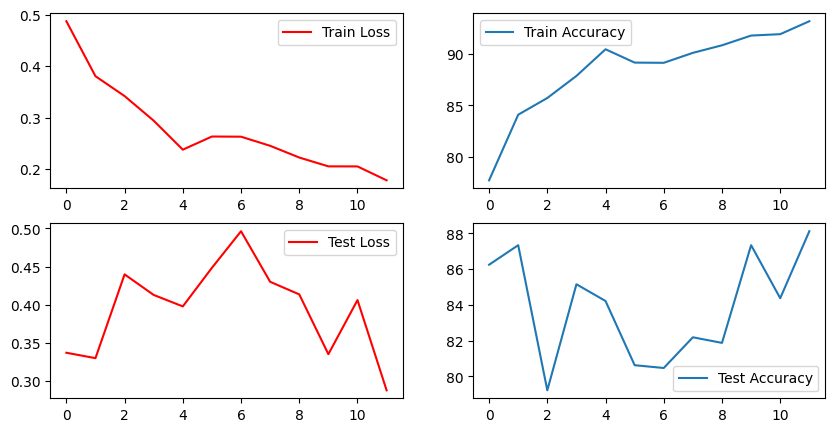


Best epoch: 11 (0 based counting)

-------------------------------------------------------

Confusion Matrix:



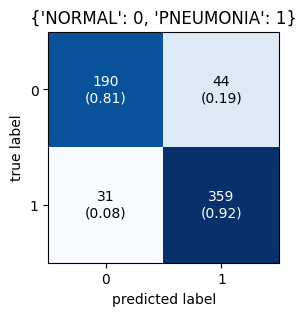


Sensitivity is: 92.05%
Specificity is: 81.20%

-------------------------------------------------------

AUROC for NORMAL (Class 0): 0.947
AUROC for PNEUMONIA (Class 1): 0.947


In [ ]:
if evaluate_status: evaluate_model(model_1,
                    MODEL_NAME,
                    test_dataLoader,
                    trl = train_loss_list,
                    trac = train_acc_list,
                    tstl = test_loss_list,
                    tstac = test_acc_list)